In [1]:
import functions as f
import tokenizer_vars as tv

from Text2 import *
from LSTM_class import *
import constants as c

from keras import layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
from transformers import BertTokenizer, GPT2Tokenizer

w:\anaconda3\envs\Viver\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
number_of_recipes = c.NUMBER_OF_RECIPES
tokenizer = tv.getTokenizer()

In [3]:
tokenizer.decode(tokenizer.encode('<RECIPE_START> <NER_START> brown sugar <NER_NEXT> milk <NER_NEXT> vanilla <NER_NEXT> nuts <NER_NEXT> butter <NER_NEXT>').ids)
# tokenizer.encode('<RECIPE_START> <NER_START> brown sugar <NER_NEXT> milk <NER_NEXT> vanilla <NER_NEXT> nuts <NER_NEXT> butter <NER_NEXT>').tokens

'<RECIPE_START> <NER_START> brown sugar <NER_NEXT> milk <NER_NEXT> vanilla <NER_NEXT> nuts <NER_NEXT> butter <NER_NEXT>'

In [4]:
path_train, path_test = f'data/train_{number_of_recipes}.txt', f'data/test_{number_of_recipes}.txt'
input_train = f.read_txt(path_train)

In [5]:
max_len = 4
step = 3

token2ind = tokenizer.get_vocab()
ind2token = {ind: token for token, ind in token2ind.items()}

text_train = Text2(input_train, token2ind=token2ind, ind2token=ind2token)
text_train.tokens_info()

seq_train = Sequences(text_train, max_len, step)
seq_train.sequences_info()

total indices: 34045944
number of sequences of length 4: 11348647


In [6]:
# print(input_train[:500])
# print(text_train.tokens[:50])
# print(text_train.tokens_ind[:50], '\n')

# np.array(seq_train.sequences[:2])

In [7]:
def lstm_model(sequence_length, vocab_size, layer_size):
    model = models.Sequential()
    model.add(layers.Embedding(vocab_size, layer_size))
    model.add(layers.Bidirectional(layers.LSTM(layer_size, return_sequences = True)))    
    model.add(layers.Dropout(0.3))
    model.add(layers.LSTM(layer_size))
    model.add(layers.Dense(vocab_size, activation='softmax'))
    return model

In [8]:
batch_size_emb = 2048

params_emb = {
    'sequence_length': max_len,
    'vocab_size': len(tokenizer.get_vocab()),
    'batch_size': batch_size_emb,
    'shuffle': True,
    'embedding': True
}

train_generator_emb = TextDataGenerator(seq_train.sequences, seq_train.next_words, **params_emb)

In [9]:
model_emb = lstm_model(max_len, len(tokenizer.get_vocab()), 512)
optimizer = optimizers.RMSprop(lr=0.001)
model_emb.compile(loss='categorical_crossentropy', optimizer=optimizer)
model_emb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 512)         15366656  
                                                                 
 bidirectional (Bidirectiona  (None, None, 1024)       4198400   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 1024)        0         
                                                                 
 lstm_1 (LSTM)               (None, 512)               3147776   
                                                                 
 dense (Dense)               (None, 30013)             15396669  
                                                                 
Total params: 38,109,501
Trainable params: 38,109,501
Non-trainable params: 0
____________________________________________

C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [10]:
early_stopping_callback = callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [11]:
history = model_emb.fit(
  train_generator_emb,
  steps_per_epoch=len(train_generator_emb),
  epochs=30,
  verbose=1,
  callbacks=[
      early_stopping_callback
  ]
)

Epoch 1/30


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/dense/MatMul' defined at (most recent call last):
    File "w:\anaconda3\envs\Viver\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "w:\anaconda3\envs\Viver\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "w:\anaconda3\envs\Viver\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "w:\anaconda3\envs\Viver\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "w:\anaconda3\envs\Viver\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "w:\anaconda3\envs\Viver\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "w:\anaconda3\envs\Viver\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "w:\anaconda3\envs\Viver\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "w:\anaconda3\envs\Viver\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "w:\anaconda3\envs\Viver\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "w:\anaconda3\envs\Viver\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "w:\anaconda3\envs\Viver\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "w:\anaconda3\envs\Viver\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "w:\anaconda3\envs\Viver\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "w:\anaconda3\envs\Viver\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "w:\anaconda3\envs\Viver\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "w:\anaconda3\envs\Viver\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "w:\anaconda3\envs\Viver\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "w:\anaconda3\envs\Viver\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "w:\anaconda3\envs\Viver\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "w:\anaconda3\envs\Viver\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Viver\AppData\Local\Temp\ipykernel_22612\2009400014.py", line 1, in <module>
      history = model_emb.fit(
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Viver\AppData\Roaming\Python\Python38\site-packages\keras\layers\core\dense.py", line 221, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential/dense/MatMul'
OOM when allocating tensor with shape[4096,30013] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/dense/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_8184]

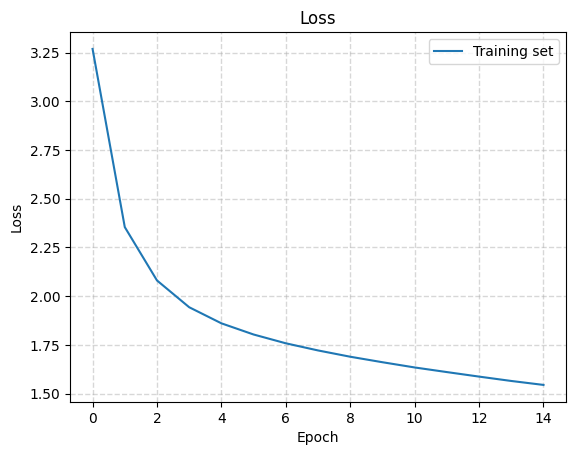

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

In [ ]:
model_emb.save("data/out/blstm_model_{NUMBER_OF_RECIPES}_emb_chef_tokenizer_long")

INFO:tensorflow:Assets written to: data/out/blstm_model_20000_emb_bert_tokenizer_long\assets


INFO:tensorflow:Assets written to: data/out/blstm_model_20000_emb_bert_tokenizer_long\assets
